In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras import regularizers
from keras import layers
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.optimizers import Adam

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))
from src.utils.utils import plot_history

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Detecção câncer de mama

### Importação

In [2]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(
        f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_{SELECTED_DATABASE}.csv"
    )
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,mean,std,smoothness,third_moment,uniformity,entropy,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,...,contrast_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology
0,48.740517,69.161480,0.999791,358860.22000,0.200536,5.016586,0.973884,1.207874,0.818646,1.100704,...,13.136905,0.436872,0.436375,0.441163,0.436264,0.190857,0.190423,0.194625,0.190326,benign
1,141.443480,83.451770,0.999856,-395556.28000,0.012593,7.079600,1.585178,2.083517,1.511726,1.816926,...,9.150162,0.076132,0.074058,0.077510,0.074861,0.005796,0.005485,0.006008,0.005604,benign
2,144.866200,16.232676,0.996219,-920.71340,0.018904,5.942641,1.951363,3.030352,2.238424,2.151287,...,8.114714,0.047273,0.038695,0.044550,0.045281,0.002235,0.001497,0.001985,0.002050,benign
3,144.866200,16.232676,0.996219,-920.71340,0.018904,5.942641,1.951363,3.030352,2.238424,2.151287,...,8.114714,0.047273,0.038695,0.044550,0.045281,0.002235,0.001497,0.001985,0.002050,benign
4,169.276860,11.590163,0.992611,954.18365,0.028183,5.460941,1.925804,2.417109,2.163486,2.590991,...,10.947381,0.057407,0.052007,0.054592,0.050196,0.003296,0.002705,0.002980,0.002520,benign


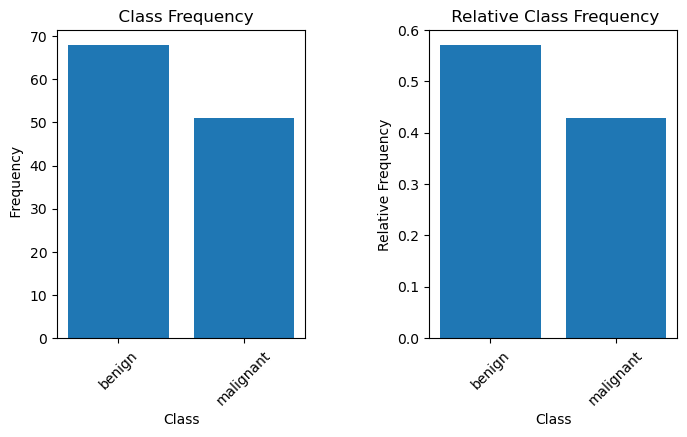

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Balanceamento dos dados
if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
elif SELECTED_DATABASE in ["cmmd"]:
    random_under_sampler = RandomUnderSampler()
    X_train, y_train = random_under_sampler.fit_resample(X_train, y_train)

# Reduz a dimensionalidade
pca = PCA(n_components=5, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

# Padroniza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[9.99999781e-01 1.48865916e-07 5.80286052e-08 1.08707373e-08
 6.79304139e-10]
[1.72541265e+10 2.56855191e+03 1.00123311e+03 1.87565117e+02
 1.17208021e+01]


### Treinamento dos modelos

In [5]:
def create_mlp_model(shape):
    model = Sequential()
    model.add(layers.Dense(24, input_dim=shape, kernel_regularizer=regularizers.L1(0.007)))
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.3))

    #model.add(layers.Dense(24))
    #model.add(layers.Activation("relu"))
    #model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    model.add(layers.Activation("sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])
    return model

1/1 [==============================] - 0s 21ms/step
Train Random Forest: 0.9837743918738304
Valid Random Forest: 0.6848484848484848

Train KNN: 0.9930232558139535
Valid KNN: 0.6658008658008658

Train MLP: 0.7360064153969527
Valid MLP: 0.6380952380952382



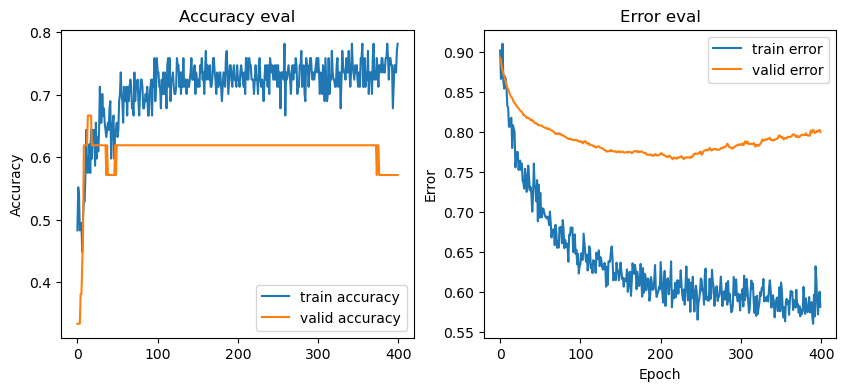

In [6]:
epochs = 400
batch_size = 4
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = {"Random Forest": [], "KNN": [], "MLP": []}
train_scores = {"Random Forest": [], "KNN": [], "MLP": []}
history = None

# bests { neurons: 24, layers: 1, dropout: 0.3, l1: 0.001, learning_rate: 0.0005, epochs: 300, batch_size: 4 }

for train_index, valid_index in kf.split(X_train):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                                criterion='entropy', max_depth=8,
                                                max_features='sqrt', n_estimators=70,
                                                min_samples_split=3, min_samples_leaf=2,
                                                n_jobs=-1)

    knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

    mlp_model = create_mlp_model(X_train.shape[1])

    models_names = ["Random Forest", "KNN", "MLP"]
    models = [random_forest_model, knn_model, mlp_model]

    for model, name in zip(models, models_names):
        if name == "MLP":
            history = model.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, verbose=None,
                                validation_data=(X_valid_cv, y_valid_cv))
            y_train_pred = model.predict(X_train_cv)
            y_valid_pred = model.predict(X_valid_cv)

            y_valid_pred = (y_valid_pred > 0.5).astype(int)
            y_train_pred = (y_train_pred > 0.5).astype(int)

            valid_accuracy = accuracy_score(y_valid_cv, y_valid_pred)
            train_accuracy = accuracy_score(y_train_cv, y_train_pred)

            scores[name].append(valid_accuracy)
            train_scores[name].append(train_accuracy)
            continue

        model.fit(X_train_cv, y_train_cv)
        y_valid_pred = model.predict(X_valid_cv)
        y_train_pred = model.predict(X_train_cv)

        train_accuracy = accuracy_score(y_train_cv, y_train_pred)
        valid_accuracy = accuracy_score(y_valid_cv, y_valid_pred)

        scores[name].append(valid_accuracy)
        train_scores[name].append(train_accuracy)

for name in models_names:
    print(f"Train {name}: {sum(train_scores[name])/len(train_scores[name])}")
    print(f"Valid {name}: {sum(scores[name])/len(scores[name])}\n")

plot_history(history)

In [7]:
""" # Models
random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                             criterion='entropy', max_depth=8,
                                             max_features='sqrt', n_estimators=70,
                                             min_samples_split=3, min_samples_leaf=2,
                                             n_jobs=-1)

knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=15, p=1, weights='distance')

mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "KNN", "MLP"]
models = [random_forest_model, knn_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100 """

' # Models\nrandom_forest_model = RandomForestClassifier(bootstrap=True, class_weight=\'balanced\',\n                                             criterion=\'entropy\', max_depth=8,\n                                             max_features=\'sqrt\', n_estimators=70,\n                                             min_samples_split=3, min_samples_leaf=2,\n                                             n_jobs=-1)\n\nknn_model = KNeighborsClassifier(algorithm=\'auto\', leaf_size=10, n_neighbors=15, p=1, weights=\'distance\')\n\nmlp_model = create_mlp_model(X_train.shape[1])\n\nthreshold = 0.5\ntitles = ["Random Forest", "KNN", "MLP"]\nmodels = [random_forest_model, knn_model, mlp_model]\nscores = {}\n\nfor model, title in zip(models, titles):\n    predict = []\n    if title == "MLP":\n        model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)\n        predict = model.predict(X_test)\n        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos\n    els

### Avaliação dos modelos

In [8]:
# scores_df = pd.DataFrame(scores).T
# scores_df

In [9]:
""" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df """

" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]\n\ncolumns=['Random Forest', 'Boosted Tree', 'MLP']\ndf = pd.DataFrame(result, columns=columns)\n\ndef mean_without_extremes(df):\n    new_df = pd.DataFrame(columns=df.columns)\n    for col in df.columns:\n        df.sort_values(by=col, inplace=True)\n        df[col] = df[col].drop(df[col].index[[0, -1]])\n        new_df[col] = [df[col].mean()]\n    return new_df\n\ndf = mean_without_extremes(df)\ndf "